In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'D:\Data set\P16-Self-Organizing-Maps\Self_Organizing_Maps\Credit_Card_Applications.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
CustomerID    690 non-null int64
A1            690 non-null int64
A2            690 non-null float64
A3            690 non-null float64
A4            690 non-null int64
A5            690 non-null int64
A6            690 non-null int64
A7            690 non-null float64
A8            690 non-null int64
A9            690 non-null int64
A10           690 non-null int64
A11           690 non-null int64
A12           690 non-null int64
A13           690 non-null int64
A14           690 non-null int64
Class         690 non-null int64
dtypes: float64(3), int64(13)
memory usage: 86.4 KB


In [3]:
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [8]:
X = df.iloc[:,:-1].values
X.shape

(690, 15)

In [9]:
Y = df.iloc[:,-1].values
Y.shape

(690,)

# feature scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

In [12]:
X.shape

(690, 15)

# SOM

In [17]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal



In [18]:
"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))

In [19]:
class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

In [20]:
class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))

In [22]:
som = MiniSom(x=10,y=10,input_len=15,sigma=1.0,learning_rate=0.5)

In [23]:
som.random_weights_init(X)
som.train_random(data = X,num_iteration =100)

In [24]:
from pylab import bone,pcolor,colorbar,plot,show

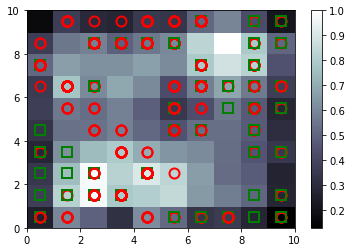

In [33]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o','s']
colors = ['r','g']
for i,x in enumerate(X):
    w = som.winner(x)
    plot(w[0]+0.5,w[1]+0.5,markers[Y[i]],markeredgecolor = colors[Y[i]],markerfacecolor = 'None',markersize =10,markeredgewidth = 2)
show()

In [34]:
mappings = som.win_map(X)
mappings

defaultdict(list,
            {(6,
              7): [array([0.84268147, 1.        , 0.12526316, 0.40928571, 0.5       ,
                     0.23076923, 0.375     , 0.05561404, 0.        , 0.        ,
                     0.        , 1.        , 0.5       , 0.05      , 0.01212   ]), array([0.72114172, 1.        , 0.15533835, 0.32142857, 0.5       ,
                     0.38461538, 0.375     , 0.00877193, 0.        , 0.        ,
                     0.        , 1.        , 0.5       , 0.        , 0.        ]), array([0.92090226, 1.        , 0.2681203 , 0.02678571, 0.        ,
                     0.38461538, 0.375     , 0.12280702, 0.        , 0.        ,
                     0.        , 1.        , 0.5       , 0.16      , 0.        ]), array([0.89100585, 1.        , 0.09398496, 0.39446429, 0.5       ,
                     0.53846154, 0.375     , 0.07017544, 0.        , 0.        ,
                     0.        , 1.        , 0.5       , 0.068     , 0.        ]), array([0.7976967 , 1. 

In [35]:
frauds =  np.concatenate((mappings[(8,1)],mappings[(2,1)],mappings[(2,2)]),axis=0)

In [36]:
frauds

array([[8.94918091e-01, 1.00000000e+00, 7.14285714e-02, 7.14285714e-02,
        5.00000000e-01, 1.53846154e-01, 3.75000000e-01, 5.26315789e-02,
        1.00000000e+00, 1.00000000e+00, 2.98507463e-02, 0.00000000e+00,
        5.00000000e-01, 6.00000000e-02, 3.00000000e-03],
       [8.50041445e-01, 1.00000000e+00, 4.24812030e-01, 3.49642857e-01,
        5.00000000e-01, 1.00000000e+00, 8.75000000e-01, 2.79298246e-01,
        1.00000000e+00, 1.00000000e+00, 1.19402985e-01, 0.00000000e+00,
        5.00000000e-01, 0.00000000e+00, 0.00000000e+00],
       [6.33366569e-01, 1.00000000e+00, 3.38345865e-01, 1.78571429e-01,
        5.00000000e-01, 5.38461538e-01, 5.00000000e-01, 8.77192982e-02,
        1.00000000e+00, 1.00000000e+00, 8.95522388e-02, 0.00000000e+00,
        5.00000000e-01, 0.00000000e+00, 3.67000000e-03],
       [5.26955219e-01, 1.00000000e+00, 4.12330827e-01, 1.44285714e-01,
        5.00000000e-01, 9.23076923e-01, 8.75000000e-01, 2.45614035e-01,
        1.00000000e+00, 1.00000000e+0

In [37]:
frauds_list = sc.inverse_transform(frauds)
print(frauds_list)

[[1.5789201e+07 1.0000000e+00 1.8500000e+01 2.0000000e+00 2.0000000e+00
  3.0000000e+00 4.0000000e+00 1.5000000e+00 1.0000000e+00 1.0000000e+00
  2.0000000e+00 0.0000000e+00 2.0000000e+00 1.2000000e+02 3.0100000e+02]
 [1.5777994e+07 1.0000000e+00 4.2000000e+01 9.7900000e+00 2.0000000e+00
  1.4000000e+01 8.0000000e+00 7.9600000e+00 1.0000000e+00 1.0000000e+00
  8.0000000e+00 0.0000000e+00 2.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.5723884e+07 1.0000000e+00 3.6250000e+01 5.0000000e+00 2.0000000e+00
  8.0000000e+00 5.0000000e+00 2.5000000e+00 1.0000000e+00 1.0000000e+00
  6.0000000e+00 0.0000000e+00 2.0000000e+00 0.0000000e+00 3.6800000e+02]
 [1.5697310e+07 1.0000000e+00 4.1170000e+01 4.0400000e+00 2.0000000e+00
  1.3000000e+01 8.0000000e+00 7.0000000e+00 1.0000000e+00 1.0000000e+00
  8.0000000e+00 0.0000000e+00 2.0000000e+00 3.2000000e+02 1.0000000e+00]
 [1.5778290e+07 1.0000000e+00 2.5000000e+01 1.1250000e+01 2.0000000e+00
  8.0000000e+00 4.0000000e+00 2.5000000e+00 1.0000000e+00 1.

In [38]:
frauds_list.shape

(40, 15)